## SETUP

In [1]:
# @title HARDWARE_INFO
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Tue Mar 30 05:33:52 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.56       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   43C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
try:
  if INSTALLED is None:
    raise EnvironmentError
  if INSTALLED != True:
    raise EnvironmentError
except:
  !pip install pandas > /dev/null
  !pip install transformers > /dev/null
  !pip install matplotlib > /dev/null
  !pip install tqdm > /dev/null
  !pip install sklearn > /dev/null
  !pip install lightgbm > /dev/null
  !pip install torch > /dev/null
  !pip install geopy > /dev/null
  !pip install seaborn > /dev/null
  !pip install sentencepiece > /dev/null
  !pip install texthero > /dev/null
  !pip install rank_bm25 > /dev/null
  #fastText
  !git clone https://github.com/facebookresearch/fastText.git > /dev/null
  !pip install fastText > /dev/null
  !rm -rf fastText > /dev/null
  !wget -N https://dl.fbaipublicfiles.com/fasttext/supervised-models/lid.176.bin > /dev/null
  !git clone https://github.com/junjunjunk/ml_utils.git
INSTALLED = True

Cloning into 'fastText'...
remote: Enumerating objects: 3854, done.
remote: Total 3854 (delta 0), reused 0 (delta 0), pack-reused 3854
Receiving objects: 100% (3854/3854), 8.22 MiB | 30.96 MiB/s, done.
Resolving deltas: 100% (2417/2417), done.
--2021-03-30 05:34:31--  https://dl.fbaipublicfiles.com/fasttext/supervised-models/lid.176.bin
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 104.22.75.142, 172.67.9.4, 104.22.74.142, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|104.22.75.142|:443... connected.
HTTP request sent, awaiting response... 304 Not Modified
File ‘lid.176.bin’ not modified on server. Omitting download.

fatal: destination path 'ml_utils' already exists and is not an empty directory.


In [3]:
# https://www.guruguru.science/competitions/16/discussions/38448796-6580-4560-bc1d-68159c0e4c34/
# https://www.guruguru.science/competitions/16/discussions/b14d0693-fe4b-4ba8-9e67-533f84dd87ad/

In [4]:
# ==================
# library
# ==================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import os
import warnings
from pathlib import PurePath
from pathlib import Path

import scipy.sparse as sp
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import normalize
from sklearn.utils.validation import FLOAT_DTYPES, check_array, check_is_fitted
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer,CountVectorizer
from sklearn.preprocessing import normalize
from sklearn.utils.validation import FLOAT_DTYPES, check_array, check_is_fitted
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import Pipeline
import cv2

from tqdm import tqdm_notebook as tqdm
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
import lightgbm as lgb
import torch
from tqdm import tqdm
import re
import seaborn as sns
from collections import Counter

from geopy.geocoders import Nominatim
from fasttext import load_model
from psutil import virtual_memory
from transformers import BertTokenizer,XLMRobertaTokenizer
import transformers
import texthero as hero
import nltk

from ml_utils.utils.cache import Cache
from ml_utils.algorithm.encoding import target_encode

%matplotlib inline
pd.set_option('display.max_columns', 300)
tqdm.pandas()

/usr/local/lib/python3.7/dist-packages/tqdm/std.py:658: FutureWarning:

The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version



In [5]:
# @title PATH_SETTING
# ==================
# Constant
# ==================
DATA_DIR = Path('./')
TRAIN_PATH = PurePath(DATA_DIR,"train.csv")
TEST_PATH = PurePath(DATA_DIR,"test.csv")
SUB_PATH =  PurePath(DATA_DIR,"atmacup10__sample_submission.csv")
SAVE_TEST_SUB_PATH = PurePath(DATA_DIR,"lgb_baseline.csv")

In [6]:
#@title LGBM_PARAMS
# ===============
# Settings
# ===============

SEED = 0
N_SPLITS = 5
SHUFFLE = True
LGBM_PARAMS = {'num_leaves': 32,
               'min_data_in_leaf': 64,
               'objective': 'regression',
               'max_depth': -1,
               'learning_rate': 0.05,
               "boosting": "gbdt",
               "bagging_freq": 1,
               "bagging_fraction": 0.8,
               "bagging_seed": SEED,
               "verbosity": -1,
              'reg_alpha': 0.1,
              'reg_lambda': 0.3,
              'colsample_bytree': 0.7,
              'metric':"rmse",
              'num_threads':6,
         }

LGBM_FIT_PARAMS = {
    'num_boost_round': 10000,
    'early_stopping_rounds': 200,
    'verbose_eval': 200,
}

In [7]:
cols = []
cat_cols = []

In [8]:
# =====================
# Function
# =====================
def train_lgbm(X_train, y_train, X_valid, y_valid, X_test, categorical_features, feature_name, fold_id,lgb_params, fit_params, loss_func):
    
    train = lgb.Dataset(X_train, y_train,
                        categorical_feature=categorical_features,
                        feature_name=feature_name)
    if X_valid is not None:
        valid = lgb.Dataset(X_valid, y_valid,
                            categorical_feature=categorical_features,
                            feature_name=feature_name)
        
    model = None
   
    if X_valid is not None:
        model = lgb.train(
            lgb_params,
            train,
            valid_sets=[train,valid],
            **fit_params
        )
    else:
        model = lgb.train(
            lgb_params,
            train,
            **fit_params
        )
    
    # train score
    if X_valid is not None:
        y_pred_valid = model.predict(X_valid)
        valid_loss = loss_func(y_valid, y_pred_valid)
    else:
        y_pred_valid = None
        valid_loss = None
    
    #test
    if X_test is not None:
        y_pred_test = model.predict(X_test)
    else:
        y_pred_test = None

    return model,y_pred_valid, y_pred_test, valid_loss

def calc_loss(y_true, y_pred):
    return  np.sqrt(mean_squared_error(y_true, y_pred))

In [9]:
# @title BM25
class BM25Transformer(TransformerMixin, BaseEstimator):
    """Transform a count matrix to a normalized tf or Okapi BM25 representation

    Parameters
    ----------
    norm : {'l1', 'l2'}, default='l2'
        Each output row will have unit norm, either:
        * 'l2': Sum of squares of vector elements is 1. The cosine
        similarity between two vectors is their dot product when l2 norm has
        been applied.
        * 'l1': Sum of absolute values of vector elements is 1.
        See :func:`preprocessing.normalize`

    Attributes
    ----------
    idf : array of shape (n_features)
        The inverse document frequency (IDF) vector;

    Examples
    --------
    >>> from sklearn.feature_extraction.text import TfidfTransformer
    >>> from sklearn.feature_extraction.text import CountVectorizer
    >>> from sklearn.pipeline import Pipeline
    >>> import numpy as np
    >>> corpus = ['this is the first document',
    ...           'this document is the second document',
    ...           'and this is the third one',
    ...           'is this the first document']
    >>> vocabulary = ['this', 'document', 'first', 'is', 'second', 'the',
    ...               'and', 'one']
    >>> pipe = Pipeline([('count', CountVectorizer(vocabulary=vocabulary)),
    ...                  ('tfid', TfidfTransformer())]).fit(corpus)
    >>> pipe['count'].transform(corpus).toarray()
    array([[1, 1, 1, 1, 0, 1, 0, 0],
           [1, 2, 0, 1, 1, 1, 0, 0],
           [1, 0, 0, 1, 0, 1, 1, 1],
           [1, 1, 1, 1, 0, 1, 0, 0]])
    >>> pipe['tfid'].idf
    array([1.        , 1.22314355, 1.51082562, 1.        , 1.91629073,
           1.        , 1.91629073, 1.91629073])
    >>> pipe.transform(corpus).shape
    (4, 8)
    """

    def __init__(self, norm="l2", k1=1.2, b=0.75):
        self.norm = norm
        self.k1 = k1
        self.b = b
        self.avdl = None

    def fit(self, X, y=None):
        """Learn(Calculate) the idf vector (global term weights).
        Parameters
        ----------
        X : sparse matrix of shape n_samples, n_features)
            A matrix of term/token counts. (CountVector)
        """
        X = check_array(X, accept_sparse=("csr", "csc"))
        if not sp.issparse(X):
            X = sp.csr_matrix(X)
        dtype = X.dtype if X.dtype in FLOAT_DTYPES else np.float64

        # Calc idf
        n_samples, n_features = X.shape

        # document_length
        dl = X.sum(axis=1)
        # average of document length
        self.avgdl = np.mean(dl)

        document_frequency = self._document_frequency(X)
        # NOTE: copy=False is necessary for scipy >= 1.1
        document_frequency = document_frequency.astype(dtype, copy=False)
        idf = np.log((n_samples - document_frequency + 0.5) / (document_frequency + 0.5))
        self._idf_diag = sp.diags(
            idf, offsets=0, shape=(n_features, n_features), format="csr", dtype=dtype
        )

        return self

    def transform(self, X, copy=True):
        """Transform a count matrix to a tf or tf-idf representation
        Parameters
        ----------
        X : sparse matrix of (n_samples, n_features)
            a matrix of term/token counts (CountVector)
        copy : bool, default=True
            Whether to copy X and operate on the copy or perform in-place
            operations.
        Returns
        -------
        vectors : sparse matrix of shape (n_samples, n_features)
        """
        X = check_array(X, accept_sparse="csr", dtype=FLOAT_DTYPES, copy=copy)
        if not sp.issparse(X):
            X = sp.csr_matrix(X, dtype=np.float64)

        n_samples, n_features = X.shape

        check_is_fitted(self, attributes=["idf"], msg="idf vector is not fitted")

        expected_n_features = self._idf_diag.shape[0]
        if n_features != expected_n_features:
            raise ValueError(
                "Input has n_features=%d while the model"
                " has been trained with n_features=%d"
                % (n_features, expected_n_features)
            )

        # document length: Shape=(n_sample)
        dl = np.sum(X,axis=1)
        sz = X.indptr[1:] - X.indptr[0:-1]
        rep = np.repeat(np.asarray(dl), sz)

        denominator = X.data + self.k1 * (1 - self.b + self.b  * (rep / self.avgdl))

        dtype = X.dtype if X.dtype in FLOAT_DTYPES else np.float64

        X[X.nonzero()] = ((X[X.nonzero()] * (self.k1 + 1)) / (denominator))
        X = X * self._idf_diag
        if self.norm:
            X = normalize(X, norm=self.norm, copy=False)

        return X

    @classmethod
    def _document_frequency(self, X):
        """Count the number of non-zero values for each feature in sparse X."""
        if sp.isspmatrix_csr(X):
            return np.bincount(X.indices, minlength=X.shape[1])
        else:
            return np.diff(X.indptr)

    @property
    def idf(self):
        # if _idf_diag is not set, this will raise an attribute error,
        # which means hasattr(self, "idf") is False
        return np.ravel(self._idf_diag.sum(axis=0))


class BM25Vectorizer(CountVectorizer):
    r"""Convert a collection of raw documents to a matrix of BM25 features.

    See Also
    --------
    CountVectorizer : Transforms text into a sparse matrix of n-gram counts.

    Notes
    -----
    The ``stop_words_`` attribute can get large and increase the model size
    when pickling. This attribute is provided only for introspection and can
    be safely removed using delattr or set to None before pickling.
    Examples
    --------
    >>> from sklearn.feature_extraction.text import TfidfVectorizer
    >>> corpus = [
    ...     'This is the first document.',
    ...     'This document is the second document.',
    ...     'And this is the third one.',
    ...     'Is this the first document?',
    ... ]
    >>> vectorizer = TfidfVectorizer()
    >>> X = vectorizer.fit_transform(corpus)
    >>> print(vectorizer.get_feature_names())
    ['and', 'document', 'first', 'is', 'one', 'second', 'the', 'third', 'this']
    >>> print(X.shape)
    (4, 9)
    """

    def __init__(
        self,
        *,
        input="content",
        encoding="utf-8",
        decode_error="strict",
        strip_accents=None,
        lowercase=True,
        preprocessor=None,
        tokenizer=None,
        analyzer="word",
        stop_words=None,
        token_pattern=r"(?u)\b\w\w+\b",
        ngram_range=(1, 1),
        max_df=1.0,
        min_df=1,
        max_features=None,
        vocabulary=None,
        binary=False,
        dtype=np.float64,
        norm="l2"
    ):

        super().__init__(
            input=input,
            encoding=encoding,
            decode_error=decode_error,
            strip_accents=strip_accents,
            lowercase=lowercase,
            preprocessor=preprocessor,
            tokenizer=tokenizer,
            analyzer=analyzer,
            stop_words=stop_words,
            token_pattern=token_pattern,
            ngram_range=ngram_range,
            max_df=max_df,
            min_df=min_df,
            max_features=max_features,
            vocabulary=vocabulary,
            binary=binary,
            dtype=dtype,
        )

        self._bm25 = BM25Transformer(norm=norm)

    # Broadcast the TF-IDF parameters to the underlying transformer instance
    # for easy grid search and repr

    @property
    def norm(self):
        return self._bm25.norm

    @norm.setter
    def norm(self, value):
        self._bm25.norm = value

    @property
    def idf(self):
        return self._bm25.idf

    @idf.setter
    def idf(self, value):
        self._validate_vocabulary()
        if hasattr(self, "vocabulary_"):
            if len(self.vocabulary_) != len(value):
                raise ValueError(
                    "idf length = %d must be equal "
                    "to vocabulary size = %d" % (len(value), len(self.vocabulary))
                )
        self._bm25.idf = value

    def _check_params(self):
        if self.dtype not in FLOAT_DTYPES:
            warnings.warn(
                "Only {} 'dtype' should be used. {} 'dtype' will "
                "be converted to np.float64.".format(FLOAT_DTYPES, self.dtype),
                UserWarning,
            )

    def fit(self, raw_documents, y=None):
        """Learn vocabulary and idf from training set.
        Parameters
        ----------
        raw_documents : iterable
            An iterable which yields either str, unicode or file objects.
        y : None
            This parameter is not needed to compute tfidf.
        Returns
        -------
        self : object
            Fitted vectorizer.
        """
        self._check_params()
        self._warn_for_unused_params()
        X = super().fit_transform(raw_documents)
        self._bm25.fit(X)
        return self

    def fit_transform(self, raw_documents, y=None):
        """Learn vocabulary and idf, return document-term matrix.
        This is equivalent to fit followed by transform, but more efficiently
        implemented.
        Parameters
        ----------
        raw_documents : iterable
            An iterable which yields either str, unicode or file objects.
        y : None
            This parameter is ignored.
        Returns
        -------
        X : sparse matrix of (n_samples, n_features)
            Tf-idf-weighted document-term matrix.
        """
        self._check_params()
        # fit_transform by CountVectorizer
        X = super().fit_transform(raw_documents)

        self._bm25.fit(X)
        # X is already a transformed view of raw_documents so we set copy to False
        return self._bm25.transform(X, copy=False)

    def transform(self, raw_documents):
        """Transform documents to document-term matrix.
        Uses the vocabulary and document frequencies (df) learned by fit (or
        fit_transform).
        Parameters
        ----------
        raw_documents : iterable
            An iterable which yields either str, unicode or file objects.
        Returns
        -------
        X : sparse matrix of (n_samples, n_features)
            Tf-idf-weighted document-term matrix.
        """
        check_is_fitted(self, msg="The TF-IDF vectorizer is not fitted")

        # CountVector
        X = super().transform(raw_documents)

        return self._bm25.transform(X, copy=False)

In [10]:
# @title BertSequenceVectorizer
class BertSequenceVectorizer:
    def __init__(self,model_name='bert-base-multilingual-uncased'):
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        self.model_name = model_name
        self.tokenizer = BertTokenizer.from_pretrained(self.model_name)
        self.bert_model = transformers.BertModel.from_pretrained(self.model_name)
        self.bert_model = self.bert_model.to(self.device)
        self.max_len = 128


    def vectorize(self, sentence : str) -> np.array:
        inp = self.tokenizer.encode(sentence)
        len_inp = len(inp)

        if len_inp >= self.max_len:
            inputs = inp[:self.max_len]
            masks = [1] * self.max_len
        else:
            inputs = inp + [0] * (self.max_len - len_inp)
            masks = [1] * len_inp + [0] * (self.max_len - len_inp)

        inputs_tensor = torch.tensor([inputs], dtype=torch.long).to(self.device)
        masks_tensor = torch.tensor([masks], dtype=torch.long).to(self.device)

        bert_out = self.bert_model(inputs_tensor, masks_tensor)
        seq_out, pooled_out = bert_out['last_hidden_state'], bert_out['pooler_output']

        if torch.cuda.is_available():    
            return seq_out[0][0].cpu().detach().numpy() # 0番目は [CLS] token, 768 dim の文章特徴量
        else:
            return seq_out[0][0].detach().numpy()

In [11]:
# @title RobertaSequenceVectorizer
class RobertaSequenceVectorizer:
    def __init__(self,model_name='xlm-roberta-base'):
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        self.model_name = model_name
        self.tokenizer = XLMRobertaTokenizer.from_pretrained("xlm-roberta-base")
        self.roberta_model = transformers.XLMRobertaModel.from_pretrained(self.model_name)
        self.roberta_model = self.roberta_model.to(self.device)
        self.max_len = 128

    def vectorize(self, sentence : str) -> np.array:
        inp = self.tokenizer.encode(sentence)
        len_inp = len(inp)

        if len_inp >= self.max_len:
            inputs = inp[:self.max_len]
            masks = [1] * self.max_len
        else:
            inputs = inp + [0] * (self.max_len - len_inp)
            masks = [1] * len_inp + [0] * (self.max_len - len_inp)

        inputs_tensor = torch.tensor([inputs], dtype=torch.long).to(self.device)
        masks_tensor = torch.tensor([masks], dtype=torch.long).to(self.device)

        bert_out = self.roberta_model(inputs_tensor, masks_tensor)
        seq_out, pooled_out = bert_out['last_hidden_state'], bert_out['pooler_output']

        if torch.cuda.is_available():    
            return seq_out[0][0].cpu().detach().numpy() # 0番目は [CLS] token, 768 dim の文章特徴量
        else:
            return seq_out[0][0].detach().numpy()


In [12]:
train = pd.read_csv(TRAIN_PATH)
test = pd.read_csv(TEST_PATH)
len_train = len(train)
y = np.log1p(train["likes"])
print('train shape:', train.shape)
print('test shape:', test.shape)

train shape: (12026, 19)
test shape: (12008, 18)


In [13]:
print(train.columns.to_list())

train['acquisition_year'] = pd.to_datetime(train['acquisition_date']).dt.year
test['acquisition_year'] = pd.to_datetime(test['acquisition_date']).dt.year

add_cols = ['art_series_id','principal_maker','acquisition_method',
            'acquisition_credit_line','acquisition_year','dating_period', 'dating_year_early',
            'dating_year_late',]
add_cat_cols = ['art_series_id','principal_maker','acquisition_method','acquisition_credit_line']

cols = [*cols,*add_cols]
cat_cols = [*cat_cols,*add_cat_cols]

['object_id', 'art_series_id', 'title', 'description', 'long_title', 'principal_maker', 'principal_or_first_maker', 'sub_title', 'copyright_holder', 'more_title', 'acquisition_method', 'acquisition_date', 'acquisition_credit_line', 'dating_presenting_date', 'dating_sorting_date', 'dating_period', 'dating_year_early', 'dating_year_late', 'likes']


In [14]:
# TfidfにかけてTruncatedSVDで64次元にする
@Cache('./cache')
def make_tfidf_feature(train,test,texts):
  custom_stopwords = nltk.corpus.stopwords.words('dutch') + nltk.corpus.stopwords.words('english')
  pipeline = Pipeline([
      ('tfidf', TfidfVectorizer(max_features=100000)),
      ('svd', TruncatedSVD(n_components=64)),
  ])

  for column in texts:
    text_features_tfidf_train = pd.DataFrame()
    text_features_tfidf_test = pd.DataFrame()

    raw_text = train[column]
    clean_text = hero.clean(raw_text, pipeline=[
        hero.preprocessing.fillna,
        hero.preprocessing.lowercase,
        hero.preprocessing.remove_digits,
        hero.preprocessing.remove_punctuation,
        hero.preprocessing.remove_diacritics,
        lambda x: hero.preprocessing.remove_stopwords(x, stopwords=custom_stopwords)
    ])
    # hero.visualization.wordcloud(clean_text, colormap='viridis', background_color='white')
    vectorized_text =  pd.DataFrame(pipeline.fit_transform(clean_text))
    vectorized_text = vectorized_text.add_prefix(f'{column}_tfidf_')
    text_features_tfidf_train = pd.concat([text_features_tfidf_train,vectorized_text],axis=1)

    raw_text = test[column]
    clean_text = hero.clean(raw_text, pipeline=[
        hero.preprocessing.fillna,
        hero.preprocessing.lowercase,
        hero.preprocessing.remove_digits,
        hero.preprocessing.remove_punctuation,
        hero.preprocessing.remove_diacritics,
        lambda x: hero.preprocessing.remove_stopwords(x, stopwords=custom_stopwords)
    ])
    # hero.visualization.wordcloud(clean_text, colormap='viridis', background_color='white')
    vectorized_text =  pd.DataFrame(pipeline.transform(clean_text))
    vectorized_text = vectorized_text.add_prefix(f'{column}_tfidf_')
    text_features_tfidf_test = pd.concat([text_features_tfidf_test,vectorized_text],axis=1)
    return text_features_tfidf_train,text_features_tfidf_test

texts = ['title','description','long_title','more_title','sub_title']
text_features_tfidf_train,text_features_tfidf_test = make_tfidf_feature(train,test,texts)

train = pd.concat([train,text_features_tfidf_train],axis=1)
test = pd.concat([test,text_features_tfidf_test],axis=1)
cols = [*cols,*text_features_tfidf_test.columns.to_list()]

make_tfidf_feature_a82c951e27cce59333b84b5540b1e59a has been called
make_tfidf_feature_a82c951e27cce59333b84b5540b1e59a cache not found


In [15]:
#BM25にかけてTruncatedSVDで64次元にする

@Cache('./cache')
def make_bm25_feature(train,test,texts):
  custom_stopwords = nltk.corpus.stopwords.words('dutch') + nltk.corpus.stopwords.words('english')
  pipeline = Pipeline([
      ('bm25', BM25Vectorizer(max_features=100000)),
      ('svd', TruncatedSVD(n_components=64)),
  ])

  for column in texts:
    text_features_bm25_train = pd.DataFrame()
    text_features_bm25_test = pd.DataFrame()
    raw_text = train[column]
    clean_text = hero.clean(raw_text, pipeline=[
        hero.preprocessing.fillna,
        hero.preprocessing.lowercase,
        hero.preprocessing.remove_digits,
        hero.preprocessing.remove_punctuation,
        hero.preprocessing.remove_diacritics,
        lambda x: hero.preprocessing.remove_stopwords(x, stopwords=custom_stopwords)
    ])
    # hero.visualization.wordcloud(clean_text, colormap='viridis', background_color='white')
    vectorized_text =  pd.DataFrame(pipeline.fit_transform(clean_text))
    vectorized_text = vectorized_text.add_prefix(f'{column}_bm25_')
    text_features_bm25_train = pd.concat([text_features_bm25_train,vectorized_text],axis=1)

    raw_text = test[column]
    clean_text = hero.clean(raw_text, pipeline=[
        hero.preprocessing.fillna,
        hero.preprocessing.lowercase,
        hero.preprocessing.remove_digits,
        hero.preprocessing.remove_punctuation,
        hero.preprocessing.remove_diacritics,
        lambda x: hero.preprocessing.remove_stopwords(x, stopwords=custom_stopwords)
    ])
    # hero.visualization.wordcloud(clean_text, colormap='viridis', background_color='white')
    vectorized_text =  pd.DataFrame(pipeline.transform(clean_text))
    vectorized_text = vectorized_text.add_prefix(f'{column}_bm25_')
    text_features_bm25_test = pd.concat([text_features_bm25_test,vectorized_text],axis=1)
  return text_features_bm25_train,text_features_bm25_test


texts = ['title','description','long_title','more_title','sub_title']
text_features_bm25_train,text_features_bm25_test = make_bm25_feature(train,test,texts)


train = pd.concat([train,text_features_bm25_train],axis=1)
test = pd.concat([test,text_features_bm25_test],axis=1)
cols = [*cols,*text_features_bm25_test.columns.to_list()]

make_bm25_feature_6932237b06568fb22db1dcae94479963 has been called
make_bm25_feature_6932237b06568fb22db1dcae94479963 cache not found


In [16]:
# Text系のStringlenを計算
texts = ['title','description','long_title','more_title','sub_title']
for column in texts:
        train[f"{column}_len"] =  train[column].str.len()
        test[f"{column}_len"] =  test[column].str.len()
        cols = [*cols,f"{column}_len"]

In [17]:
# Multilingual BERT vector をTruncatedSVDで32(上位解法だと６４)次元に圧縮

make_bert_texts = ['title','description','long_title']
@Cache('./cache')
def make_bert_feature(train,test,texts):
  created_feature_train = pd.DataFrame()
  created_feature_test = pd.DataFrame()
  for column in texts:
      BSV = BertSequenceVectorizer()
      svd = TruncatedSVD(n_components=64)

      tmp = train[column].fillna("NaN")
      vectorized_texts =  tmp.progress_apply(lambda x: BSV.vectorize(x))
      text_features_train = svd.fit_transform(vectorized_texts.to_list())
      text_features_train = pd.DataFrame(text_features_train)
      text_features_train = text_features_train.add_prefix(f'{column}_bert_')
      
      tmp = test[column].fillna("NaN")
      vectorized_texts =  tmp.progress_apply(lambda x: BSV.vectorize(x))
      text_features_test = svd.transform(vectorized_texts.to_list())
      text_features_test = pd.DataFrame(text_features_test)
      text_features_test = text_features_test.add_prefix(f'{column}_bert_')

      created_feature_train = pd.concat([created_feature_train,text_features_train],axis=1)
      created_feature_test = pd.concat([created_feature_test,text_features_test],axis=1)
  return created_feature_train, created_feature_test
    
text_features_train,text_features_test = make_bert_feature(train,test,make_bert_texts)

train = pd.concat([train,text_features_train],axis=1)
test = pd.concat([test,text_features_test],axis=1)

cols = [*cols,*text_features_test.columns.to_list()]

make_bert_feature_85a82b502e112c3063225e46a13f5430 has been called
make_bert_feature_85a82b502e112c3063225e46a13f5430 cache not found


100%|██████████| 12008/12008 [03:31<00:00, 56.89it/s]


In [18]:
#XLM-Robertavector をTruncatedSVDで32(上位解法だと６４)次元に圧縮
make_roberta_texts = ['title','description','long_title']

@Cache('./cache')
def make_roberta_feature(train,test,texts):
  created_feature_train = pd.DataFrame()
  created_feature_test = pd.DataFrame()
  for column in texts:
      RSV = RobertaSequenceVectorizer()
      svd = TruncatedSVD(n_components=64)

      tmp = train[column].fillna("NaN")
      vectorized_texts =  tmp.progress_apply(lambda x: RSV.vectorize(x))
      text_features_train = svd.fit_transform(vectorized_texts.to_list())
      text_features_train = pd.DataFrame(text_features_train)
      text_features_train = text_features_train.add_prefix(f'{column}_roberta_')
      
      tmp = test[column].fillna("NaN")
      vectorized_texts =  tmp.progress_apply(lambda x: RSV.vectorize(x))
      text_features_test = svd.transform(vectorized_texts.to_list())
      text_features_test = pd.DataFrame(text_features_test)
      text_features_test = text_features_test.add_prefix(f'{column}_roberta_')

      created_feature_train = pd.concat([created_feature_train,text_features_train],axis=1)
      created_feature_test = pd.concat([created_feature_test,text_features_test],axis=1)
  return created_feature_train, created_feature_test

text_features_train,text_features_test = make_roberta_feature(train,test,make_roberta_texts)

train = pd.concat([train,text_features_train],axis=1)
test = pd.concat([test,text_features_test],axis=1)
cols = [*cols,*text_features_test.columns.to_list()]

make_roberta_feature_0cd9e0559374dd611a0c8c9226b8c88c has been called
make_roberta_feature_0cd9e0559374dd611a0c8c9226b8c88c cache not found


100%|██████████| 12008/12008 [03:30<00:00, 56.93it/s]


In [19]:
model = load_model("./lid.176.bin")
for column in ['title','description','long_title']:
    new_column = f"{column}_lang_ft"
    train[new_column] = train[column].fillna("").map(lambda x: model.predict(x.replace("\n", ""))[0][0])
    test[new_column] = train[column].fillna("").map(lambda x: model.predict(x.replace("\n", ""))[0][0])
    cols = [*cols,new_column]
    cat_cols = [*cat_cols, new_column]

In [20]:
## sub_title からサイズ情報を抽出
for axis in ['h', 'w', 't', 'd']:
    column_name = f'size_{axis}'
    size_info = train['sub_title'].str.extract(r'{} (\d*|\d*\.\d*)(cm|mm)'.format(axis)) # 正規表現を使ってサイズを抽出
    size_info = size_info.rename(columns={0: column_name, 1: 'unit'})
    size_info[column_name] = size_info[column_name].replace('', np.nan).astype(float) # dtypeがobjectになってるのでfloatに直す
    size_info[column_name] = size_info.apply(lambda row: row[column_name] * 10 if row['unit'] == 'cm' else row[column_name], axis=1) # 　単位をmmに統一する
    train[column_name] = size_info[column_name]

for axis in ['h', 'w', 't', 'd']:
    column_name = f'size_{axis}'
    size_info = test['sub_title'].str.extract(r'{} (\d*|\d*\.\d*)(cm|mm)'.format(axis)) # 正規表現を使ってサイズを抽出
    size_info = size_info.rename(columns={0: column_name, 1: 'unit'})
    size_info[column_name] = size_info[column_name].replace('', np.nan).astype(float) # dtypeがobjectになってるのでfloatに直す
    size_info[column_name] = size_info.apply(lambda row: row[column_name] * 10 if row['unit'] == 'cm' else row[column_name], axis=1) # 　単位をmmに統一する
    test[column_name] = size_info[column_name]
    cols = [*cols, column_name]

# 面積
train['size_hw'] = train['size_h'] * train['size_w']
test['size_hw'] = test['size_h'] * test['size_w']
cols = [*cols, 'size_hw']

train['dim'] = train['sub_title'].str.count('×')+1
test['dim'] = test['sub_title'].str.count('×')+1
cols = [*cols, 'dim']

In [21]:
# サイズ情報をグルーピング
size_stat = train[['size_h', 'size_w', 'size_t', 'size_d']].agg(['max', 'min', 'std', 'mean', 'median'], axis=1)
size_stat['max-min'] = size_stat['max']-size_stat['min']
size_stat['max/min'] = size_stat['max']/size_stat['min']
size_stat = size_stat.add_prefix(f'{column}_')
train = pd.concat([train,size_stat],axis=1)

size_stat = test[['size_h', 'size_w', 'size_t', 'size_d']].agg(['max', 'min', 'std', 'mean', 'median'], axis=1)
size_stat['max-min'] = size_stat['max']-size_stat['min']
size_stat['max/min'] = size_stat['max']/size_stat['min']
size_stat = size_stat.add_prefix(f'{column}_')
test = pd.concat([test,size_stat],axis=1)
cols = [*cols,*size_stat.columns.to_list()]

In [22]:
# maker 一部ORIGINAL
maker_df = pd.read_csv(Path(DATA_DIR,'maker.csv'))
train = train.merge(maker_df,how='left',left_on='principal_maker',right_on='name')
test = test.merge(maker_df,how='left',left_on='principal_maker',right_on='name')

train['date_of_death'] = train['date_of_death'].map(lambda x: str(x)[:4])
test['date_of_death'] = test['date_of_death'].map(lambda x: str(x)[:4])
train['date_of_death'] = train['date_of_death'].astype('float')
test['date_of_death'] = test['date_of_death'].astype('float')

train['date_of_birth'] = train['date_of_birth'].map(lambda x: str(x)[:4])
test['date_of_birth'] = test['date_of_birth'].map(lambda x: str(x)[:4])
train['date_of_birth'] = train['date_of_birth'].astype('float')
test['date_of_birth'] = test['date_of_birth'].astype('float')

## 制作した年の作者の年齢　ちょっときいた
train['dating_age_early'] = train['dating_year_early'] - train['date_of_birth']
test['dating_age_early'] = test['dating_year_early'] - test['date_of_birth']

train['dating_age_late'] = train['dating_year_late'] - train['date_of_birth']
test['dating_age_late'] = test['dating_year_late'] - test['date_of_birth']

cols = [*cols,'date_of_birth','date_of_death','dating_age_early','dating_age_late']

In [23]:
historical_persion_df = pd.read_csv(Path(DATA_DIR,'historical_person.csv'))
historical_persion_df = historical_persion_df.groupby('object_id').count().rename(columns={'name':'count_person'})

train = train.merge(historical_persion_df,how='left',on='object_id')
test = test.merge(historical_persion_df,how='left',on='object_id')

cols = [*cols,'count_person']

In [24]:
# ORIGINAL
@Cache('./cache')
def make_color_feature(train,test):
  palette_df = pd.read_csv(Path(DATA_DIR,'palette.csv'))
  palette_df = palette_df.sort_values('ratio', ascending=False)
  base_color_df = palette_df.drop_duplicates('object_id',keep='first').add_prefix('base_')

  palette_df = pd.read_csv(Path(DATA_DIR,'palette.csv'))
  palette_df = palette_df.merge(base_color_df,how='left',left_on='object_id',right_on='base_object_id')

  palette_df['vivid'] = palette_df.apply(lambda x:(
                              (x['base_color_r']-x['color_r'])**2+ 
                              (x['base_color_g']-x['color_g'])**2+ 
                              (x['base_color_b']-x['color_b'])**2)*x['ratio'],axis=1)

  palette_df['vivid'] = np.sqrt(palette_df['vivid'])
  color_df = palette_df[['object_id','vivid']].groupby('object_id').sum().reset_index()
  return base_color_df,color_df

base_color_df,color_df = make_color_feature(train,test)

train = train.merge(color_df,how='left',on='object_id')
test = test.merge(color_df,how='left',on='object_id')

train = train.merge(base_color_df,how='left',left_on='object_id',right_on='base_object_id')
test = test.merge(base_color_df,how='left',left_on='object_id',right_on='base_object_id')

cols = [*cols,'base_color_r','base_color_g','base_color_b','vivid']

make_color_feature_55fc3a2d233a067546fe98b27677387e has been called
make_color_feature_55fc3a2d233a067546fe98b27677387e cache not found


In [25]:
count_feature = []
# count encofing(frequency)
for c in ['art_series_id', 'principal_maker', 'principal_or_first_maker', 
       'copyright_holder', 'more_title', 'acquisition_method',
       'acquisition_date', 'acquisition_credit_line', 'dating_presenting_date',
       'dating_sorting_date', 'dating_period', 'dating_year_early',
       'dating_year_late']:
    new_column = f"count_{c}"
    freq = train[c].value_counts()
    train[new_column] = train[c].map(freq)
    test[new_column] = test[c].map(freq)
    cols=[*cols, new_column]

In [26]:
from gensim.models import word2vec, KeyedVectors

material_df = pd.read_csv(Path(DATA_DIR,'material.csv'))
technique_df = pd.read_csv(Path(DATA_DIR,'technique.csv'))
collection_df = pd.read_csv(Path(DATA_DIR,'object_collection.csv'))

mat_col = pd.concat([material_df, collection_df], axis=0).reset_index(drop=True)
mat_tec = pd.concat([material_df, technique_df], axis=0).reset_index(drop=True)
col_tec = pd.concat([collection_df, technique_df], axis=0).reset_index(drop=True)
mat_col_tec = pd.concat([material_df, collection_df, technique_df], axis=0).reset_index(drop=True)

mat_col_tec.groupby("object_id")["name"].apply(list)

# 単語ベクトル表現の次元数
# 元の語彙数をベースに適当に決めました
model_size = {
    "material": 20,
    "technique": 8,
    "collection": 3,
    "material_collection": 20,
    "material_technique": 20,
    "collection_technique": 10,
    "material_collection_technique": 25
}

n_iter = 100

w2v_dfs = []
for df, df_name in zip(
        [
            material_df, collection_df, technique_df,
            mat_col, mat_tec, col_tec, mat_col_tec
        ], [
            "material", "collection", "technique",
            "material_collection",
            "material_technique",
            "collection_technique",
            "material_collection_technique"
        ]):
    df_group = df.groupby("object_id")["name"].apply(list).reset_index()
    # Word2Vecの学習
    w2v_model = word2vec.Word2Vec(df_group["name"].values.tolist(),
                                  size=model_size[df_name],
                                  min_count=1,
                                  window=10,
                                  iter=n_iter)

    # 各文章ごとにそれぞれの単語をベクトル表現に直し、平均をとって文章ベクトルにする
    sentence_vectors = df_group["name"].progress_apply(
        lambda x: np.mean([w2v_model.wv[e] for e in x], axis=0))
    sentence_vectors = np.vstack([x for x in sentence_vectors])
    sentence_vector_df = pd.DataFrame(sentence_vectors,
                                      columns=[f"{df_name}_w2v_{i}"
                                               for i in range(model_size[df_name])])
    sentence_vector_df.index = df_group["object_id"]
    w2v_dfs.append(sentence_vector_df)

for tdf in w2v_dfs:
  train = pd.merge(train,tdf,how='left',on='object_id')
  test =  pd.merge(test,tdf,how='left',on='object_id')
  cols = [*cols,*tdf.columns.to_list()]

100%|██████████| 23953/23953 [00:00<00:00, 27670.62it/s]


In [27]:
def target_encode(
    c: str,
    train_df: pd.DataFrame,
    test_df: pd.DataFrame = None,
    label: str = "label",
    n_splits: int = 5,
    shuffle: bool = True,
    random_state: int = 42,
    is_straitified: bool = False,
) -> None:
    """Target Encoding function (inplace)

    Args:
        c (str): Name of category column
        train_df (pd.DataFrame): Train DataFrame
        test_df (pd.DataFrame, optional): Test DataFrame. Defaults to None.
        label (string, optional): Name of label column. Defaults to 'label'.
        n_splits (int, optional): The number of folds. Defaults to 5.
        shuffle (bool, optional): enable shuffle. Defaults to True.
        random_state (int, optional): seed number. Defaults to 42.
        is_straitified (bool,optional): valid straitified KFold. Defaults to True.

    """

    # Encoding test data with all the train data
    if test_df is not None:
        target_mean = train_df[[c, label]].groupby(c)[label].mean()
        test_df[f"target_{c}"] = test_df[c].map(target_mean)

    # Encoding train data

    ts = pd.Series(np.empty(train_df.shape[0]), index=train_df.index)

    if is_straitified:
        folds = StratifiedKFold(
            n_splits=n_splits, shuffle=shuffle, random_state=random_state
        )

        for main_idx, rest_idx in folds.split(train_df, train_df[label]):
            target_mean = train_df[[c, label]].iloc[main_idx].groupby(c)[label].mean()
            ts[rest_idx] = train_df[c].iloc[rest_idx].map(target_mean)
    else:
        folds = KFold(n_splits=n_splits, shuffle=shuffle, random_state=random_state)

        for main_idx, rest_idx in folds.split(train_df):
            target_mean = train_df[[c, label]].iloc[main_idx].groupby(c)[label].mean()
            ts[rest_idx] = train_df[c].iloc[rest_idx].map(target_mean)

    train_df[f"target_{c}"] = ts


In [28]:
object_collection_df = pd.read_csv(Path(DATA_DIR,'object_collection.csv'))

vc = object_collection_df['name'].value_counts()
use_names = vc[vc > 10].index
idx = object_collection_df['name'].isin(use_names)
object_collection_df = object_collection_df[idx].reset_index(drop=True)

cross_object_collection = pd.crosstab(object_collection_df['object_id'],object_collection_df['name'])
cross_object_collection = cross_object_collection.add_prefix('cross_object_collection_')

train = train.merge(cross_object_collection,how='left',on='object_id')
test = test.merge(cross_object_collection,how='left',on='object_id')


cross_object_collection_columns = cross_object_collection.columns.to_list()
cols = [*cols,*cross_object_collection_columns]
cat_cols = [*cat_cols,*cross_object_collection_columns]


In [29]:
material_df = pd.read_csv(Path(DATA_DIR,'material.csv'))

vc = material_df['name'].value_counts()
use_names = vc[vc > 10].index
idx = material_df['name'].isin(use_names)
material_df = material_df[idx].reset_index(drop=True)

cross_material = pd.crosstab(material_df['object_id'],material_df['name'])
cross_material = cross_material.add_prefix('cross_material_')

train = train.merge(cross_material,how='left',on='object_id')
test = test.merge(cross_material,how='left',on='object_id')

cross_material_columns = cross_material.columns.to_list()
cols = [*cols,*cross_material_columns]
cat_cols = [*cat_cols,*cross_material_columns]


In [30]:
# colorのhexに対してのword2vec(効くの？)
# principal_maker_occupationのname
# historical_personのname

In [31]:
# groupby
# カテゴリカル変数をキーとしてsizeやyearのmin, max, mean
# aggregationしたものと元データのdiff, ratio

In [32]:
for c in ['principal_maker','principal_or_first_maker','copyright_holder','acquisition_method','acquisition_credit_line']:
    target_encode(c,train,test,'likes')
    cols = [*cols,f"target_{c}"]

In [33]:
## 互いに存在しないカテゴリは削除
for c in sorted(cat_cols):
    print(c)
    train.loc[~train[c].isin(test[c].unique()),c] = np.nan
    test.loc[~test[c].isin(train[c].unique()),c] = np.nan
# df = pd.concat([train[cols],test[cols]]).reset_index(drop=True)
df = pd.concat([train,test]).reset_index(drop=True)

acquisition_credit_line
acquisition_method
art_series_id
cross_material_RC paper
cross_material_baryta paper
cross_material_canvas
cross_material_cardboard
cross_material_celluloid (cellulosic)
cross_material_chalk
cross_material_copper (metal)
cross_material_deck paint
cross_material_glass
cross_material_hardboard
cross_material_ink
cross_material_leather
cross_material_linen (material)
cross_material_metal
cross_material_oak (wood)
cross_material_oil paint (paint)
cross_material_paint (coating)
cross_material_panel
cross_material_paper
cross_material_pencil
cross_material_photographic paper
cross_material_printing ink
cross_material_silk
cross_material_tempera
cross_material_velvet (fabric weave)
cross_material_watercolor (paint)
cross_material_wood (plant material)
cross_object_collection_Navy Model Room
cross_object_collection_dollhouse
cross_object_collection_drawings
cross_object_collection_paintings
cross_object_collection_paper
cross_object_collection_prints
description_lang_ft

In [34]:
for c in cat_cols:
    df[c] = df[c].astype(str)
    le = LabelEncoder()
    df[c] = le.fit_transform(df[c])

In [35]:
test = df.iloc[len_train:].reset_index(drop=True)
train = df.iloc[:len_train].reset_index(drop=True)
train['likes'] = y

In [36]:
#art_series_idをgroupとしたGroupKFold(n_split=5)

In [37]:
# principal_makerでtarget encoding

In [38]:
models = []
kf = KFold(n_splits=N_SPLITS,random_state=SEED, shuffle=SHUFFLE)
y_oof = np.empty([len(train),])
y_test = []
features = cols
feature_importances = pd.DataFrame()
categorical_features = cat_cols


for fold, (train_idx, valid_idx) in enumerate(kf.split(train,y)):
    print('Fold {}'.format(fold + 1))
    for c in ['principal_maker','principal_or_first_maker','copyright_holder','acquisition_method','acquisition_credit_line']:
       tmp_train = train.iloc[train_idx].copy().reset_index(drop=True)
       tmp_valid = train.iloc[valid_idx].copy().reset_index(drop=True)
       target_encode(c,tmp_train,tmp_valid,label='likes')
    x_train, y_train = tmp_train[features], y.iloc[train_idx]
    x_val, y_val = tmp_valid[features], y.iloc[valid_idx]
    
    model,y_pred_valid, y_pred_test, valid_loss = train_lgbm(
                x_train, y_train, x_val, y_val,test[features],
                categorical_features=categorical_features,
                feature_name=features,
                fold_id=fold,
                lgb_params=LGBM_PARAMS,
                fit_params=LGBM_FIT_PARAMS,
                loss_func=calc_loss
            )
    models.append(model)
    
    y_oof[valid_idx] = y_pred_valid
    score = calc_loss(y[valid_idx], y_pred_valid)
    y_test.append(y_pred_test)

score = calc_loss(y, y_oof)
print(score)

Fold 1


/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:1205: UserWarning:

Using categorical_feature in Dataset.

/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:762: UserWarning:

categorical_feature in param dict is overridden.



Training until validation scores don't improve for 200 rounds.
[200]	training's rmse: 0.640137	valid_1's rmse: 0.993021
[400]	training's rmse: 0.441719	valid_1's rmse: 0.984378
[600]	training's rmse: 0.322631	valid_1's rmse: 0.984855
Early stopping, best iteration is:
[475]	training's rmse: 0.390344	valid_1's rmse: 0.983768
Fold 2


/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:1205: UserWarning:

Using categorical_feature in Dataset.

/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:762: UserWarning:

categorical_feature in param dict is overridden.



Training until validation scores don't improve for 200 rounds.
[200]	training's rmse: 0.640216	valid_1's rmse: 0.979395
[400]	training's rmse: 0.441988	valid_1's rmse: 0.975447
Early stopping, best iteration is:
[367]	training's rmse: 0.468239	valid_1's rmse: 0.974757
Fold 3


/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:1205: UserWarning:

Using categorical_feature in Dataset.

/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:762: UserWarning:

categorical_feature in param dict is overridden.



Training until validation scores don't improve for 200 rounds.
[200]	training's rmse: 0.631223	valid_1's rmse: 1.03202
[400]	training's rmse: 0.434229	valid_1's rmse: 1.02562
Early stopping, best iteration is:
[394]	training's rmse: 0.438779	valid_1's rmse: 1.02541
Fold 4


/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:1205: UserWarning:

Using categorical_feature in Dataset.

/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:762: UserWarning:

categorical_feature in param dict is overridden.



Training until validation scores don't improve for 200 rounds.
[200]	training's rmse: 0.637281	valid_1's rmse: 0.998402
[400]	training's rmse: 0.43989	valid_1's rmse: 0.991288
[600]	training's rmse: 0.321728	valid_1's rmse: 0.991414
Early stopping, best iteration is:
[482]	training's rmse: 0.385291	valid_1's rmse: 0.990576
Fold 5


/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:1205: UserWarning:

Using categorical_feature in Dataset.

/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:762: UserWarning:

categorical_feature in param dict is overridden.



Training until validation scores don't improve for 200 rounds.
[200]	training's rmse: 0.638344	valid_1's rmse: 0.995447
[400]	training's rmse: 0.44074	valid_1's rmse: 0.992717
[600]	training's rmse: 0.322057	valid_1's rmse: 0.992985
Early stopping, best iteration is:
[435]	training's rmse: 0.41607	valid_1's rmse: 0.991727
0.9933956810387686


In [39]:
y_test_sub =  np.mean(y_test,axis=0)
y_test_sub = np.expm1(y_test_sub)
sub = pd.read_csv(SUB_PATH)
sub["likes"] = y_test_sub
sub.loc[sub.likes <= 0,"likes"] = 0
sub.to_csv(SAVE_TEST_SUB_PATH,index=False)

In [40]:
models[0]

(<Figure size 576x900 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f68d96d7410>)

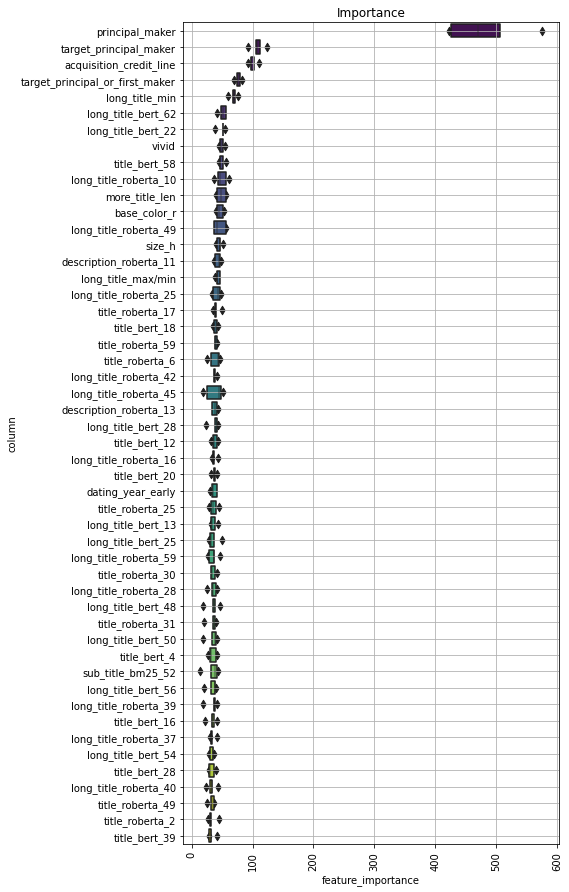

In [41]:
def visualize_importance(models, feat_train_df,filter_columns=[]):
    """lightGBM の model 配列の feature importance を plot する
    CVごとのブレを boxen plot として表現します.

    args:
        models:
            List of lightGBM models
        feat_train_df:
            学習時に使った DataFrame
    """
    feature_importance_df = pd.DataFrame()
    for i, model in enumerate(models):
        _df = pd.DataFrame()
        _df['feature_importance'] = model.feature_importance()
        _df['column'] = feat_train_df.columns
        _df['fold'] = i + 1
        feature_importance_df = pd.concat([feature_importance_df, _df],
                                          axis=0, ignore_index=True)
    
    order = feature_importance_df.groupby('column')\
        .sum()[['feature_importance']]\
        .sort_values('feature_importance', ascending=False).index[:50]
    
    if len(filter_columns)>0:
        feature_importance_df = feature_importance_df[feature_importance_df['column'].isin(filter_columns)]
        order = feature_importance_df.groupby('column')\
        .sum()[['feature_importance']]\
        .sort_values('feature_importance', ascending=False).index[:50]

    fig, ax = plt.subplots(figsize=(8, max(6, len(order) * .25)))
    sns.boxenplot(data=feature_importance_df,
                  x='feature_importance',
                  y='column',
                  order=order,
                  ax=ax,
                  palette='viridis',
                  orient='h')
    ax.tick_params(axis='x', rotation=90)
    ax.set_title('Importance')
    ax.grid()
    fig.tight_layout()
    return fig, ax


visualize_importance(models,train[features])


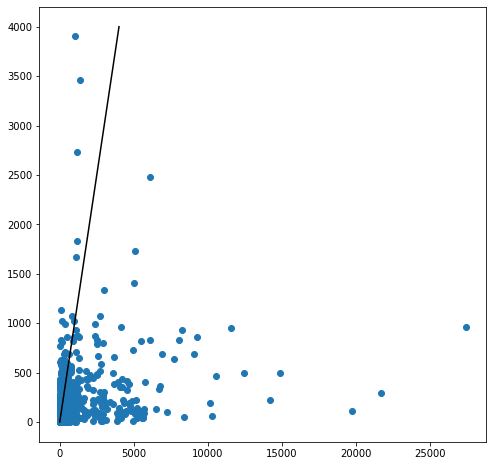

In [42]:
y_train_oof = np.expm1(y_oof)

fig, ax = plt.subplots(figsize=(8, 8))
# ax.title('oof vs pred')
ax.plot([0,4000], [0,4000], color='black')
ax.scatter( np.expm1(y), np.expm1(y_oof))

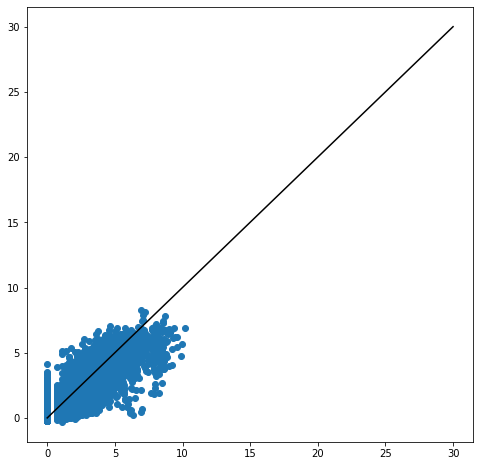

In [43]:
y_train_oof = np.expm1(y_oof)

fig, ax = plt.subplots(figsize=(8, 8))
# ax.title('oof vs pred')
ax.plot([0,30], [0,30], color='black')
ax.scatter(y, y_oof)